In [1]:
#!pip install pycocotools

In [2]:
!pip install segmentation_models 

In [3]:
!pip install keras-segmentation

In [4]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import copy 

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [5]:
def unnormalizeAnns(anns, x, y):
    for i in range(0, 8):
        if i % 2 == 0:
            anns['segmentation'][0][i] = anns['segmentation'][0][i] * x
        else:
            anns['segmentation'][0][i] = anns['segmentation'][0][i] * y
    return anns

In [6]:
def filterDataset(folder, classes=None):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [7]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

In [8]:
def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'].split('/')[2])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img

In [9]:
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        anns = copy.deepcopy(anns[a])
        new_mask = cv2.resize(coco.annToMask(unnormalizeAnns(anns,192,192))*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask 

In [10]:
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


In [11]:
#imageObj = images[0]
#imageObj

In [12]:
#img_folder = '../data/Rathausen_192x192'
#train_img = getImage(imageObj, img_folder, input_image_size)
#train_img

In [13]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(192,192), batch_size=4, mode='train', mask_type='normal'):
    
    img_folder = '{}/'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            #print(i)
            
            imageObj = images[i]
            #print(imageObj)
            
            #print('images loaded')
            try :
                imageObj['width'] = 192
                imageObj['height'] = 192
            except :
                #print(imageObj)
                print("not able to set the images size")
            
            ### Retrieve Image ###
            try:
                train_img = getImage(imageObj, img_folder, input_image_size)
            except:
                next
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        print("end loop")
        c+=batch_size
        print(c)
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [14]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

In [15]:
# Starting with the Feature prep

In [16]:
folder = '../data/Rathausen_192x192'
classes = ['Photovoltaik-Modul']
mode = ''

images, dataset_size, coco = filterDataset(folder, classes)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [17]:
batch_size = 4
input_image_size = (192,192)
mask_type = 'normal'

gen = dataGeneratorCoco(images, classes, coco, folder,
                            input_image_size, batch_size, mode, mask_type)

end loop
4


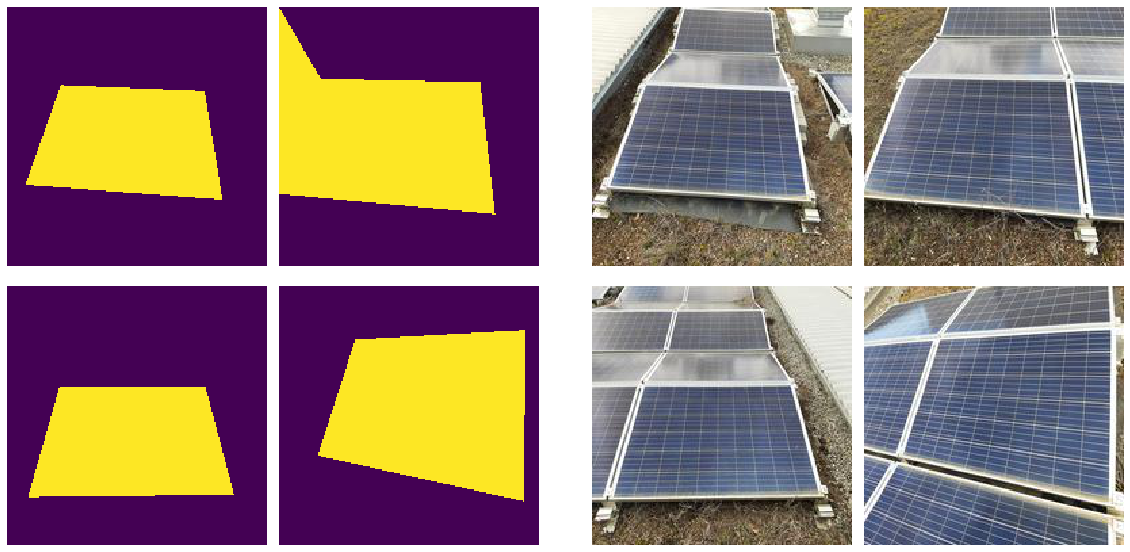

In [18]:
visualizeGenerator(gen)

In [19]:
#train_dataset = filterDataset(folder, classes)

#train_gen = dataGeneratorCoco(train_dataset[0], classes, coco, folder, 
#                            input_image_size, batch_size, mode, mask_type)


In [20]:
#train_dataset[0]

In [21]:
img, mask = next(gen)

end loop
8


In [22]:
mask.shape

(4, 192, 192, 1)

In [23]:
data

NameError: name 'data' is not defined

In [126]:
batch_size = 4

In [127]:
# Set your parameters
n_epochs = 1

steps_per_epoch = 12 // batch_size
validation_steps = 12 // batch_size

In [206]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import keras
import keras as K
#from segmentation_models import Unet
#import segmentation_models as sm

# load the VGG16 network and initialize the label encoder
print("[INFO] loading network...")
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=[192,192,3], classes=1)


[INFO] loading network...


In [207]:
to_res = (192,192)

In [209]:
    model = K.models.Sequential()
    model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
    model.add(base_model)
    model.add(K.layers.Flatten())
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(256, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(128, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(64, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(10, activation='softmax'))

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [190]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [187]:
inputs = keras.Input(shape=(192, 192, 3))

In [191]:
x = data_augmentation(inputs) 

In [192]:
x = tf.keras.applications.xception.preprocess_input(x)


In [200]:
x = base_model(x, training=True)
#x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  
outputs = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')
model = keras.Model(inputs, outputs)

ValueError: Input 0 of layer conv1_pad is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 2048)

In [211]:
import tensorflow as tf
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

opt = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
loss_fn = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)
# Compile your model first
model.compile(loss = loss_fn, optimizer = opt, metrics=['accuracy'])

In [212]:
# Start the training process
history = model.fit(x = gen,
                steps_per_epoch = steps_per_epoch,
                epochs = n_epochs,
                verbose = True)

end loop
8


ValueError: in user code:

    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\ckw-haec\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 10) vs (None, None, None, None))


In [213]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 192, 192, None)    0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 73728)             294912    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               18874624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)              